# Libraries

In [80]:
# Data wrangling
from matplotlib.pylab import f
import pandas as pd
import numpy as np

# Data visualisation
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Machine learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer

# My functions
import sys
sys.path.insert(0, "../../src")
from run_mp import *
from nfi_wrangling import *

# Other
from os import error
import datetime
from io import StringIO
import re
import warnings

# Global Settings

In [81]:
# NFI file name
nfi_file_name = "20231201-103649_nfi_dataset_for_analysis copy.csv"

# Folder prefix
folder_suffix = ""  # None for no prefix

# Random Forest
target = "mort_ba_prc_yr_v1"  # Target variable
na_drop_threshold = 0.1  # If more than this proportion of NA values, drop the column
seed_nr = 42  # Seed number for reproducibility
test_split = 0.2  # Test/train splitting
test_train_strata = [
    # "gre",
    "campagne_1",
    "top1_species_nfi",
]  # Strata for test/train splitting

user_input = {
    "target": "mort_ba_prc_yr_v1",  # Target variable
    "na_drop_threshold": 0.05,  # If more than this proportion of NA values, drop the column
    "seed_nr": 42,  # Seed number for reproducibility
    "test_split": 0.2,  # Test/train splitting
    "cv_folds": 5,  # Folds to use in cross-validation (in REFCV, in GridSearchCV, in )
    "test_train_strata": [
        # "gre",
        "campagne_1",
        "top1_species_nfi",
    ],  # Strata for test/train splitting
    "do_random_search": False,  # If True, do random search
    "do_prescribed_search": False,  # If True, do prescribed search
    "do_ref": True,  # If True, do REF
}

# Data Wrangling
add_gee_data = True
rerun_calculation_growth_mortality = False
run_reports_major = True
run_reports_minor = False

In [82]:
# GREY = KEEP
# GREEN = REMOVED
# If not specified otherwise in google sheet or in routine

user_input_variable_removal = [
    # ! Variables with temporal information
    "campagne_1",
    "campagne_2",
    "visite_1",
    "visite_2",
    "census_interval",
    # ! Variables with spatial information
    "ser",
    "gre",
    "dep",
    "lat",
    "lon",
    "lat_fr",
    "lon_fr",
    # ! Variables from NFI derivatives that hold ba information
    # "site_ba_prc_cut_at_v2",
    # "site_ba_prc_dead_at_v1",
    "site_ba_prc_dead_at_v2",
    # "site_ba_prc_rec_at_v2",
    "site_total_ba_at_v1",
    "site_total_ba_at_v2",
    # ! Variables from calculation_growth_mortality:
    # * General variables / stand descriptions
    "idp",
    "n_plots",
    "n_ini",
    "n_sur",
    "n_fin",
    "n_rec",
    "n_die",
    "ba_at_v1_of_alive_trees",
    "ba_at_v2_of_alive_trees",
    "ba_at_v1_of_survivors",
    "ba_at_v2_of_survivors",
    "ba_at_v1_of_dead",
    "ba_at_v2_of_dead",
    "ba_at_v2_of_recruits",
    # * Growth and Mortality variables
    "mort_stems_prc_yr_esq",
    "mort_stems_prc_yr_hoshino",
    "rec_stems_prc_yr_hoshino",
    "mort_ba_prc_yr_hoshino",
    "tot_growth_ba_prc_yr_hoshino",
    "sur_growth_ba_prc_yr_hoshino",
    "tot_growth_ba_yr",
    "sur_growth_ba_yr",
    "mort_ba_yr_v1",
    "mort_ba_yr_v2",
    "tot_growth_ba_prc_yr",
    "sur_growth_ba_prc_yr",
    "mort_ba_prc_yr_v1",  # <--- Target variable
    "mort_ba_prc_yr_v2",
]

# 📜 Functions

In [83]:
def create_new_run_folder(folder_suffix=None):
    # Get today's date
    today = datetime.date.today().strftime("%Y-%m-%d")

    # Create the subdirectory in "model_runs" with today's date as the name
    subdirectory = os.path.join("model_runs", today)
    os.makedirs(subdirectory, exist_ok=True)

    # Set folder pattern in daily folder
    folder_pattern = "run_"

    # Filter subdirectory to regex match the folder_pattern (omits other files and folders)
    all_folders = [
        folder
        for folder in os.listdir(subdirectory)
        if re.match(folder_pattern, folder)
    ]

    # Count the number of folders in the subdirectory
    num_folders = len(all_folders)

    # print(num_folders, all_folders)

    # Create a new folder with the name "run_n" where n is the number of folders + 1
    if num_folders < 9:
        folder_nr = f"0{num_folders + 1}"
    else:
        folder_nr = num_folders + 1

    new_folder = os.path.join(subdirectory, f"{folder_pattern}{folder_nr}")

    if folder_suffix:
        new_folder += f"_{folder_suffix}"

    os.makedirs(new_folder)

    return new_folder

In [84]:
def get_current_folder():
    # Get today's date
    today = datetime.date.today().strftime("%Y-%m-%d")

    # Create the subdirectory in "model_runs" with today's date as the name
    subdirectory = os.path.join("model_runs", today)

    # Set folder pattern in daily folder
    folder_pattern = "run_"

    # Filter subdirectory to regex match the folder_pattern (omits other files and folders)
    all_folders = [
        folder
        for folder in os.listdir(subdirectory)
        if re.match(folder_pattern, folder)
    ]

    # Since folders are sorted by run number, the last in the list is the newest
    # print(sorted(all_folders))
    current_folder = sorted(all_folders)[-1]
    return current_folder

In [85]:
def plot_grid_search_results(grid):
    """
    Params:
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results["mean_test_score"]
    stds_test = results["std_test_score"]
    means_train = results["mean_train_score"]
    stds_train = results["std_train_score"]

    ## Getting indexes of values per hyper-parameter
    masks = []
    masks_names = list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results["param_" + p_k].data == p_v))

    params = grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1, len(params), sharex="none", sharey="all", figsize=(20, 5))
    fig.suptitle("Score per parameter")
    fig.text(0.04, 0.5, "MEAN SCORE", va="center", rotation="vertical")
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i + 1 :])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle="--", marker="o", label="test")
        ax[i].errorbar(x, y_2, e_2, linestyle="-", marker="^", label="train")
        ax[i].set_xlabel(p.upper())

    plt.legend()
    plt.show()
    # return fig

In [86]:
def show_top_predictors(
    X_train,
    vars_to_ohe,
    rf_model,
    with_aggregation=False,
    n_predictors=20,
    verbose=True,
):
    # Plot the variable importance
    importances = rf_model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]

    df_featimp = pd.DataFrame(
        {
            "Feature": X_train.columns[indices],
            "Importance": importances[indices],
        }
    )

    if verbose:
        print("Original size of df_featimp: ", df_featimp.shape)

    if with_aggregation:
        # For features matching the string in vars_to_ohe_red, sum up their importances and set name to vars_to_ohe_red
        # Make sure aggregation procedure is saved to file for checking later on:

        if verbose:
            display("Aggregating variables...")

        rows_to_drop = []
        rows_to_append = []
        text_to_save = []
        agg_dict = {}

        # vars_to_ohe_red = [var for var in vars_to_ohe if var in X_train.columns]

        # for var in vars_to_ohe_red:
        #     n_vars = 0
        #     feat_sum = 0
        #     merged_vars = []
        #     for i in range(len(df_featimp)):
        #         if var in df_featimp.loc[i, "Feature"]:
        #             merged_vars.append(df_featimp.loc[i, "Feature"])
        #             feat_sum += df_featimp.loc[i, "Importance"]
        #             n_vars += 1
        #             rows_to_drop.append(i)

        for var in vars_to_ohe:
            n_vars = 0
            feat_sum = 0
            merged_vars = []
            pattern = r"^" + var + r"_.*"

            for i in range(len(df_featimp)):
                if re.match(pattern, df_featimp.loc[i, "Feature"]):
                    merged_vars.append(df_featimp.loc[i, "Feature"])
                    feat_sum += df_featimp.loc[i, "Importance"]
                    n_vars += 1
                    rows_to_drop.append(i)

            # Attach to rows_to_append
            rows_to_append.append({"Feature": var, "Importance": feat_sum})

            # Print aggregation information
            # print(f"Merged {n_vars} vars into {var} containing: {merged_vars}")

            # Save aggregation to a dictionary
            agg_dict[var] = merged_vars

            # Save information to file
            if verbose:
                text_to_save = text_to_save + [
                    f"Merged {n_vars} vars into {var} containing:\n {merged_vars} \n\n"
                ]

        # Drop the rows that were merged
        df_featimp = df_featimp.drop(rows_to_drop)
        df_featimp = pd.concat(
            [df_featimp, pd.DataFrame(rows_to_append)], ignore_index=True
        )
        df_featimp = df_featimp.sort_values(by="Importance", ascending=False)

        if verbose:
            print("df_featimp after merging: ", df_featimp.shape)

            # Write to file
            file_path = f"{current_dir}/vip_aggregation_of_ohe_into_their_originals.txt"
            with open(file_path, "w") as file:
                for item in text_to_save:
                    file.write(f"{item}\n\n")
    else:
        agg_dict = None

    top_n = df_featimp.head(n_predictors)

    if verbose:
        # Show top n predictors table
        display(top_n)

        # Plot the variable importance
        sns_plot = sns.barplot(x="Importance", y="Feature", data=top_n, color="r")
        plt.tight_layout()

        # Save the barplot as an image file
        sns_plot.figure.savefig(
            f"{current_dir}/vip_plot_aggregated-{with_aggregation}.png"
        )

        # Save the dataframe as a tab-separated file
        df_featimp.to_csv(f"{current_dir}/vip_table_aggregated-{with_aggregation}.csv")

    # Return aggregation dictionary if needed
    return df_featimp, agg_dict

In [87]:
def assessing_top_predictors(
    rf_in,
    ignore_these,
    X_train_in,
    dict_ohe_in,
    with_aggregation=False,
    n_predictors=20,
    verbose=True,
):
    # Update n_predictors based on number of variables in X_train_in
    n_predictors = min(n_predictors, len(X_train_in.columns))

    # Get importances
    importances = rf_in.feature_importances_
    std = np.std([tree.feature_importances_ for tree in rf_in.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]

    df_featimp_org = pd.DataFrame(
        {
            "Feature": X_train_in.columns[indices],
            "Importance": importances[indices],
            "Std": std[indices],
        }
    )

    df_featimp_agg = pd.DataFrame(
        {
            "Feature": [],
            "Importance": [],
            "Std": [],
        }
    )

    if with_aggregation:
        # Remove variables to ignore from dictionary
        for var in ignore_these:
            if var in dict_ohe_in.keys():
                del dict_ohe_in[var]

        # Loop through all keys in the dictionary
        for key in dict_ohe_in.keys():
            importances_per_key = []
            stdevs_per_key = []

            # Loop through all variables in the key
            for var in dict_ohe_in[key]:
                # Loop through all variables in the original featimp df
                for i in range(len(df_featimp_org)):
                    # Check if the row in the featimp corresponds to value of the key
                    # If so, gather all variables for that key and aggregate them.
                    if df_featimp_org["Feature"].iloc[i] == var:
                        importances_per_key.append(df_featimp_org["Importance"].iloc[i])
                        stdevs_per_key.append(df_featimp_org["Importance"].iloc[i])

                n_vars_per_key = len(dict_ohe_in[key])
                if n_vars_per_key > 1:
                    importance = np.sum(importances_per_key)
                    stdev = sum([x**2 for x in stdevs_per_key])
                else:
                    importance = importances_per_key[0]
                    stdev = stdevs_per_key[0]

            new_row = pd.DataFrame(
                {
                    "Feature": [key],
                    "Importance": [importance],
                    "Std": [stdev],
                    "Importance_per_key": [importances_per_key],
                    "Vars_per_key": [n_vars_per_key],
                    "Vars_in_key": [", ".join(dict_ohe_in[key])],
                }
            )

            df_featimp_agg = pd.concat([df_featimp_agg, new_row], axis=0)
            df_featimp_final = df_featimp_agg.sort_values(
                by="Importance", ascending=False
            ).reset_index(drop=True)

    else:
        df_featimp_final = (
            df_featimp_org.copy()
            .sort_values(by="Importance", ascending=False)
            .reset_index(drop=True)
        )

    # --------------------------------------------------------
    if verbose:
        # Show top n predictors table
        top_n = df_featimp_final.head(n_predictors)
        if with_aggregation:
            my_title = f"Top {n_predictors} predictors with aggregation"
        else:
            my_title = f"Top {n_predictors} predictors without aggregation"

        # Plot the variable importance
        sns_plot = sns.barplot(x="Importance", y="Feature", data=top_n, color="r")
        sns_plot.set_title(my_title)
        plt.tight_layout()

        # Save the barplot as an image file
        # sns_plot.figure.savefig(
        #     f"{current_dir}/vip_plot_aggregated-{with_aggregation}.png"
        # )

        # Save the dataframe as a tab-separated file
        # df_featimp.to_csv(f"{current_dir}/vip_table_aggregated-{with_aggregation}.csv")

    # --------------------------------------------------------
    # Print output
    print(
        f"assessing_top_predictors()...",
        f"\n - Number of columns in X_train_in is equal to number of rows in df_featimp_org: {len(X_train_in.columns) == df_featimp_org.shape[0]}",
        f"\n - Number of vars in training set is equal to number of rows in df_featimp_agg: {len(dict_ohe_in) == df_featimp_agg.shape[0]}",
        f"\n - Size of original df_featimp_org: {df_featimp_org.shape}",
        f"\n - Size of aggregated df_featimp_agg: {df_featimp_agg.shape}",
    )

    return df_featimp_final

In [88]:
def model_evaluation(rf_model, X_test, y_test):
    # Predict on the test data
    y_pred = rf_model.predict(X_test)

    # Calculate the evaluation metrics
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    # Print the evaluation metrics
    print("R2 score: ", r2)
    print("RMSE: ", rmse)
    print("MAE: ", mae)

    # Plot the predicted against true values using seaborn
    sns.regplot(
        x=y_test,
        y=y_pred,
        scatter_kws=dict(color="gray", s=10, alpha=0.8),
        line_kws=dict(color="blue"),
    )
    plt.plot(ls="--", c="red")
    plt.xlabel("Observations")
    plt.ylabel("Predictions")
    plt.title(
        f"Predicted versus observed values of {target}\nR2 score: {round(r2, 2)}, RMSE: {round(rmse, 2)}, MAE: {round(mae, 2)}"
    )

    # Set y and x axis limits based on the maximum value in y_pred or y_test
    max_value = max(max(y_pred), max(y_test))
    plt.ylim(0, max_value)
    plt.xlim(0, max_value)

    # Add a red dotted 1:1 line
    plt.plot([0, max_value], [0, max_value], ls="--", c="r")

    # Set equal scaling (i.e., 1:1 aspect ratio)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.savefig(f"{current_dir}/predicted_vs_observed.png")
    plt.show()

In [89]:
def do_ohe(Xy, variables_not_to_ohe=[], verbose=True):
    ohe_these = []

    for var in Xy:
        if Xy[var].dtype == "O":
            ohe_these = ohe_these + [var]

    # Remove variables that should not be one-hot encoded
    ohe_these = [var for var in ohe_these if var not in variables_not_to_ohe]

    # One-hot encoding
    ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")

    df_ohe = pd.DataFrame(
        ohe.fit_transform(Xy[ohe_these]),
        columns=ohe.get_feature_names_out(ohe_these),
    )

    # Attach the non-encoded variables
    df_out = pd.concat(
        [
            Xy.drop(columns=ohe_these).reset_index(drop=True),
            df_ohe.reset_index(drop=True),
        ],
        axis=1,
    )

    # Verbose output
    if verbose:
        print(
            f"do_ohe():",
            f"\n - Shape before OHE:\t\t {Xy.shape}",
            f"\n - Shape after OHE:\t\t {df_out.shape}",
            f"\n - Change in Nr. of columns:\t {df_out.shape[1] - Xy.shape[1]} (dropped: {len(ohe_these)}, added: {df_ohe.shape[1]})",
            f"\n - Variables that were ohe:\t {' | '.join(sorted(ohe_these))}",
            f"\n - New variables:\t\t {' | '.join(sorted(df_ohe.columns.to_list()))}",
        )

    return df_out

In [90]:
def pp_this(
    vars_to_ohe,
    numerics_with_na,
    X_train,
    X_test,
    current_dir,
    verbose=True,
):
    print("FUNCTION DISABLED")

    # # Get numerical variables that have at least one NA value
    # numerics_with_na = [
    #     var for var in X_train.columns if (X_train[var].isnull().sum() > 0 and X_train[var].dtype != "O")
    # ]

    # # Reduce vars_to_ohe to only hold variables that are in the dataset
    # vars_to_ohe_red = [var for var in vars_to_ohe if var in X_train.columns]

    # # Save to file what variables have been ohe
    # file_path = f"{current_dir}/ohe_variables.txt"
    # with open(file_path, "w") as file:
    #     for item in vars_to_ohe_red:
    #         file.write(f"{item}\n")

    # # Initial variables
    # initial_vars = X_train.columns.to_list()

    # # Verbose
    # if verbose:
    #     print(f"Shape of X_train before pre-processing: {X_train.shape}")
    #     print(f"Shape of X_test before pre-processing: {X_test.shape}")

    # # One-hot encoding
    # ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")

    # X_train_encoded = pd.DataFrame(
    #     ohe.fit_transform(X_train[vars_to_ohe_red]),
    #     columns=ohe.get_feature_names_out(vars_to_ohe_red),
    # )

    # X_test_encoded = pd.DataFrame(
    #     ohe.transform(X_test[vars_to_ohe_red]),
    #     columns=ohe.get_feature_names_out(vars_to_ohe_red),
    # )

    # # Concatenate the encoded variables with the rest of the dataset
    # # A bit hacky because the index is reset, but it works
    # df1 = X_train.drop(vars_to_ohe_red, axis=1).reset_index(drop=True)
    # df2 = X_train_encoded.reset_index(drop=True)
    # X_train = pd.concat([df1, df2], axis=1)

    # df1 = X_test.drop(vars_to_ohe_red, axis=1).reset_index(drop=True)
    # df2 = X_test_encoded.reset_index(drop=True)
    # X_test = pd.concat([df1, df2], axis=1)

    # # KNN imputation
    # if len(numerics_with_na) > 0:
    #     imputer = KNNImputer(n_neighbors=5)
    #     X_train[numerics_with_na] = imputer.fit_transform(X_train[numerics_with_na])
    #     X_test[numerics_with_na] = imputer.transform(X_test[numerics_with_na])

    # # Final vars
    # final_vars = X_train.columns.to_list()

    # # Shape of train and text set
    # if verbose:
    #     print(f"\nShape of X_train after pre-processing: {X_train.shape}")
    #     print(f"Shape of X_test after pre-processing: {X_test.shape}")

    #     print(f"\nNewly added variables {len(final_vars) - len(initial_vars)}: ")
    #     [print(var, end=" | ") for var in final_vars if var not in initial_vars]

    #     # Write dataframe infos to text
    #     buffer = StringIO()
    #     X_train.info(buf=buffer, verbose=True)
    #     info_str = buffer.getvalue()
    #     file_path = f"{current_dir}/X_train_info_after_imputation.txt"
    #     with open(file_path, "w") as file:
    #         file.write(info_str)

    #     buffer = StringIO()
    #     X_test.info(buf=buffer, verbose=True)
    #     info_str = buffer.getvalue()
    #     file_path = f"{current_dir}/X_test_info_after_imputation.txt"
    #     with open(file_path, "w") as file:
    #         file.write(info_str)

    # # Return dataframes
    # return X_train, X_test

In [91]:
def impute_numerical_na(
    Xy_train_in,
    Xy_test_in,
    target_in,
    n_neighbours=10,
    vars_not_to_impute=[],
):
    # Define in and out dataframees
    Xy_train_in = Xy_train_in.copy().reset_index(drop=True)
    Xy_train_out = Xy_train_in.copy().reset_index(drop=True)

    Xy_test_in = Xy_test_in.copy().reset_index(drop=True)
    Xy_test_out = Xy_test_in.copy().reset_index(drop=True)

    # Get numerical variables with NAs
    all_numerics = Xy_train_in.columns[(Xy_train_in.dtypes != "O")].tolist()

    num_na_train = Xy_train_out.columns[
        (Xy_train_out.dtypes != "O") & (Xy_train_out.isna().any())
    ].tolist()
    num_na_test = Xy_test_out.columns[
        (Xy_test_out.dtypes != "O") & (Xy_test_out.isna().any())
    ].tolist()

    num_na_train = list(set(num_na_train + num_na_test))

    # Check if target had NA values and inform
    detected_vars = []
    for var in vars_not_to_impute:
        if var in num_na_train:
            detected_vars.append(var)
            num_na_train.remove(var)

    # Do imputation
    if len(num_na_train) > 0:
        imputer = KNNImputer(n_neighbors=n_neighbours)
        Xy_train_out[num_na_train] = imputer.fit_transform(Xy_train_out[num_na_train])
        Xy_test_out[num_na_train] = imputer.transform(Xy_test_out[num_na_train])

    print(
        f"impute_numerical_na():",
        f"\n - Shape of Xy_train before imputation: {Xy_train_in.shape}",
        f"\n - Shape of Xy_train before imputation: {Xy_train_out.shape}",
        f"\n",
        f"\n - Shape of Xy_test before imputation: {Xy_test_in.shape}",
        f"\n - Shape of Xy_test before imputation: {Xy_test_out.shape}",
        f"\n",
        f"\n - Out of {len(all_numerics)}, {len(num_na_train)} had NA values and were imputed using KNN with {n_neighbours} neighbours.",
        f"\n - Imputed variables: {' | '.join(sorted(num_na_train))}",
    )

    if len(detected_vars) > 0:
        print(
            f"\n - ❌❌❌ Variables {detected_vars} had NA values but are not meant to be imputed! They were not imputed but their values should be fixed! ❌❌❌"
        )

    return Xy_train_out, Xy_test_out

In [147]:
def hist_of_variable_in_two_df(df1, df1_name, df2, df2_name, variable):
    # Extract the desired column from each dataframe
    col1 = df1[variable]
    col2 = df2[variable]

    # Plotting the histograms
    plt.figure(figsize=(10, 6))
    plt.hist(col1, bins=20, alpha=0.5, label=df1_name, density=True)
    plt.hist(col2, bins=20, alpha=0.5, label=df2_name, density=True)

    # Adding titles and labels
    plt.title(f"Overlapping Histograms of {variable}")
    plt.xlabel(f"Level of {variable}")
    plt.ylabel("Frequency")
    plt.legend()

    # Show the plot
    plt.show()

# Data Preparation

## Load NFI Data

In [92]:
# Load NFI Data
if "nfi_final_data" not in globals():
    nfi_final_data = pd.read_csv(
        f"../00_process_nfi_data/{nfi_file_name}",
        index_col=[0],
        low_memory=False,
    )

    if run_reports_minor:
        profile = ProfileReport(
            nfi_final_data.sort_index(axis=1),
            minimal=True,
            dark_mode=True,
            title="NFI Input Data",
        )

        profile.to_file(f"report-nfi_input_data.html")

print("Shape of nfi_final_data:", nfi_final_data.shape)
print("Number of invidiual sites:", nfi_final_data["idp"].nunique())

print("Columns in nfi_final_data:")
for col in nfi_final_data.columns:
    print(f" - {col}")

# TODO: Should be done somewhere else...
# Replace where intgr is in [4L, 6A, 6H] with [4, 6, 6]
nfi_final_data["integr"] = nfi_final_data["integr"].replace(
    ["4L", "6A", "6H"], ["4", "6", "6"]
)

# TODO: FIXING TOP1_SPECIES FORMATTING
# Rename columns
nfi_final_data = nfi_final_data.rename(
    columns={
        "top1_species": "top1_species_nfi",
        "top2_species": "top2_species_nfi",
        "top3_species": "top3_species_nfi",
    }
)

Shape of nfi_final_data: (408224, 222)
Number of invidiual sites: 40022
Columns in nfi_final_data:
 - idp
 - site_total_ba_at_v1
 - site_total_ba_at_v2
 - site_ba_prc_dead_at_v1
 - site_ba_prc_dead_at_v2
 - site_ba_prc_cut_at_v2
 - site_ba_prc_rec_at_v2
 - n_species_nfi
 - top1_species_nfi
 - top1_species_ba_1_mean
 - top1_species_ba_1_sd
 - top1_species_age13_mean
 - top1_species_age13_sd
 - top1_species_ir5_mean
 - top1_species_ir5_sd
 - top1_species_v_mean
 - top1_species_v_sd
 - top1_species_htot_mean
 - top1_species_htot_sd
 - top2_species_nfi
 - top2_species_ba_1_mean
 - top2_species_ba_1_sd
 - top2_species_age13_mean
 - top2_species_age13_sd
 - top2_species_ir5_mean
 - top2_species_ir5_sd
 - top2_species_v_mean
 - top2_species_v_sd
 - top2_species_htot_mean
 - top2_species_htot_sd
 - top3_species_nfi
 - top3_species_ba_1_mean
 - top3_species_ba_1_sd
 - top3_species_age13_mean
 - top3_species_age13_sd
 - top3_species_ir5_mean
 - top3_species_ir5_sd
 - top3_species_v_mean
 - top3_

## Calculate growth and mortality

In [93]:
# Calculation of Growth / Mortality at plot-level

if "nfi_agg" not in globals() or rerun_calculation_growth_mortality:
    # Load pre-calculated dataframe
    nfi_agg = pd.read_parquet("nfi-idp_level_aggregated_growth_mortality.parquet")

    if (
        nfi_agg.shape[0] != nfi_final_data["idp"].nunique()
        or rerun_calculation_growth_mortality
    ):
        # ⚠️  This takes abnfi_agg 30 minutes to run, so loading the data from the feather file instead
        #     Plus, for some reason, after running this cell, the notebook slows down massively.

        if nfi_agg.shape[0] != nfi_final_data["idp"].nunique():
            print(
                "Number of rows in nfi_agg is not equal to number of rows in nfi_final_data, so re-running the calculation."
            )
            print("Shape of old nfi_agg:", nfi_agg.shape)

        grouped = nfi_final_data.groupby("idp", as_index=False)
        df_list = [group for name, group in grouped]

        # df_list = df_list[:100] # For debug, reduce number to 100 sites only

        nfi_agg = run_mp(
            calculate_growth_mortality,
            df_list,
            combine_func=pd.concat,
            progress_bar=True,
            num_cores=10,
        )

        # Save data
        nfi_agg.to_parquet("nfi-idp_level_aggregated_growth_mortality.parquet")

        # Create Report
        if run_reports_minor:
            profile = ProfileReport(
                nfi_agg.sort_index(axis=1),
                minimal=True,
                dark_mode=True,
                title="Overview of Growth and Mortality Calculations",
            )

            profile.to_file(f"report-growth_mortality_calculations.html")

print("Shape of final nfi_agg:", nfi_agg.shape)
print("Number of individual sites:", nfi_agg["idp"].nunique())

# for col in nfi_agg.columns:
#     print(col)

Shape of final nfi_agg: (40022, 28)
Number of individual sites: 40022


## Merge NFI and Mortality Datasets

In [94]:
# Attach growth/mortality data to nfi_final_data
nfi_merged = nfi_final_data.merge(nfi_agg, how="left", left_on="idp", right_on="idp")
print("Shape of nfi_merged:", nfi_merged.shape)

Shape of nfi_merged: (408224, 249)


## Check against Excel file

In [95]:
# Check which variables are part documented in the google sheets:

# Load original NFI Variables
nfi_org = pd.read_excel(
    "ifna_predictor_database.xlsx",
    sheet_name="NFI Original Variables",
)[["var", "type", "level", "remove"]]

# Add suffixes _1 and _2 to the original variables to distinguish them if sampled from different years
suffix_1 = nfi_org.copy()
suffix_2 = nfi_org.copy()

suffix_1["var"] = suffix_1["var"].apply(lambda x: x + "_1")
suffix_2["var"] = suffix_2["var"].apply(lambda x: x + "_2")

# Load my NFI derivatives
nfi_derivatives = (
    pd.read_excel(
        "ifna_predictor_database.xlsx",
        sheet_name="NFI Derivatives",
    )
    .reset_index()[["var", "type", "level", "remove"]]
    .dropna(subset=["type"])
)

# Concatenate original variables with suffixes and derivatives
vars_described_in_sheet = pd.concat([nfi_org, suffix_1, suffix_2, nfi_derivatives])
# vars_described_in_sheet

# Extract variables that are in the final wrangled nfi dataset
final_vars = nfi_merged.columns.to_frame(index=False, name="var").sort_values("var")

# Remove all variables that can be found in the excel file:
mask = final_vars["var"].isin(vars_described_in_sheet["var"])
not_described_vars = final_vars[~mask]

# Print output
print("Variables that are not documented in the excel (should show empty dataframe):")
display(not_described_vars)

# Check if variables are described in the excel file that are not in the final wrangled nfi dataset
# Extract all derivatives
all_ders = nfi_derivatives["var"]

# Find entries in var that are in all_ders but not in final_vars
mask = nfi_derivatives["var"].isin(final_vars["var"])
documented_but_not_in_final_df = nfi_derivatives[~mask]

# Print the output
print("Variables that are documented in the excel but not in the merged nfi dataframe:")
display(documented_but_not_in_final_df)

Variables that are not documented in the excel (should show empty dataframe):


,var


Variables that are documented in the excel but not in the merged nfi dataframe:


,var,type,level,remove
48,dom_nr1_espar_red_ba_abs,num,location,NaN
49,dom_nr1_espar_red_ba_prc,num,location,NaN
50,dom_nr1_espar_red_fct,cat,location,NaN
51,dom_nr1_genus_lat_ba_abs,num,location,NaN
52,dom_nr1_genus_lat_ba_prc,num,location,NaN
53,dom_nr1_genus_lat_fct,cat,location,NaN
54,dom_nr1_species_lat_ba_abs,num,location,NaN
55,dom_nr1_species_lat_ba_prc,num,location,NaN
56,dom_nr1_species_lat_fct,cat,location,NaN
60,dom_nr2_espar_red_ba_abs,num,location,NaN


### Get NFI Variable Encoding

In [96]:
# Get temporary df
df_tmp = nfi_merged.copy()
print("Shape of nfi_merged:", nfi_merged.shape)

# vars_described_in_sheet holds all possible suffix combinations but those are not needed.
# So, reduce vars_described_in_sheet to match variables in df_tmp
vars_described_in_sheet_and_in_df = vars_described_in_sheet[
    vars_described_in_sheet["var"].isin(df_tmp.columns)
]

Shape of nfi_merged: (408224, 249)


In [97]:
# APRIORI COLUMN REMOVAL
# Remove columns that are not needed as specified
columns_to_remove = vars_described_in_sheet_and_in_df.query("remove == 'x'")[
    "var"
].to_list()

# Make sure that idp is only removed before running the random forest
if "idp" in columns_to_remove:
    columns_to_remove.remove("idp")

columns_to_remove = sorted(columns_to_remove)

# Remove the columns from df_tmp
df_tmp = df_tmp.drop(columns=columns_to_remove)

print(f"{len(columns_to_remove)} columns removed as specified in excel file:")
for column in columns_to_remove:
    print(f" - {column}", end="\n")

print("Shape of df_tmp:", df_tmp.shape)

55 columns removed as specified in excel file:
 - a
 - age
 - age_class
 - anpyr
 - bplant_1
 - bplant_2
 - c0
 - census_interval
 - cible
 - clon
 - datemort
 - dc_1
 - dc_2
 - ddec
 - decoupe
 - forme
 - hdec
 - height_class
 - hrb
 - human_activity
 - iplant_1
 - iplant_2
 - lfsd
 - mes_c13
 - ori
 - peupnr_1
 - peupnr_2
 - q1
 - q2
 - q3
 - qualite
 - r
 - revisit_state
 - shadow_growth
 - simplif
 - tetard
 - tform_1
 - tform_2
 - tige
 - tm2
 - tpespar1_1
 - tpespar1_2
 - tpespar2_1
 - tpespar2_2
 - tree_id
 - tree_state_1
 - tree_state_2
 - videpeuplier_1
 - videpeuplier_2
 - videplant
 - visit_1
 - visit_2
 - visite_1
 - visite_2
 - w
Shape of df_tmp: (408224, 194)


In [98]:
# DATETIME VARIABLES
# TODO: dropping datetime variable for now because it is of little importance and
# TODO: encoding takes significant extra work for now...
# TODO: To keep circular nature of data structure, encode using trigonometric functions
# TODO: https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html

# Rerun this to avoid errors:
vars_described_in_sheet_and_in_df = vars_described_in_sheet[
    vars_described_in_sheet["var"].isin(df_tmp.columns)
]

date_cols = vars_described_in_sheet_and_in_df.query("type == 'date'")["var"].tolist()

for var in date_cols:
    df_tmp[var] = df_tmp[var].fillna(df_tmp["campagne_1"].astype(str) + "-07-01")

df_tmp = df_tmp.drop(columns=date_cols)
print("Shape of df_tmp:", df_tmp.shape)

Shape of df_tmp: (408224, 194)


In [99]:
# ENCODE CATEGORICAL VARIABLES

# vars_described_in_sheet holds all possible suffix combinations but those are not needed.
# So, reduce vars_described_in_sheet to match variables in df_tmp
vars_described_in_sheet_and_in_df = vars_described_in_sheet[
    vars_described_in_sheet["var"].isin(df_tmp.columns)
]

# Get list of variables to encode, based on excel file
vars_to_ohe = vars_described_in_sheet_and_in_df.query("type == 'cat'")["var"]

# Reduce to have only variables in df_tmp
vars_to_ohe = [var for var in vars_to_ohe if var in df_tmp.columns]

df_encoded = df_tmp.copy()
print(f"Shape of df_encoded: {df_encoded.shape}")

Shape of df_encoded: (408224, 194)


## Reduce data to location-level

In [100]:
# Get temporary df
df_tmp = df_encoded.copy()
print(f"Shape of df_encoded: {df_encoded.shape}")
print("Number of individual sites:", df_tmp["idp"].nunique())

# Get all variables on location-level
location_vars = vars_described_in_sheet_and_in_df.query(
    "level == 'location' or level == 'grouping'"
)
tree_vars = vars_described_in_sheet_and_in_df.query("level == 'tree'")

print("Number of tree-level variables that are removed:", tree_vars.shape[0])
print("Number of location-level variables that are kept:", location_vars.shape[0])

# Get all columns in nfi_final_data that are also in location_vars
matching_columns = [var for var in location_vars["var"] if var in df_tmp.columns]
# matching_columns = [var for var in location_vars["var"]]

# Fixes by hand because some integers are saved as floats
# sver
df_tmp["sver"] = df_tmp["sver"].replace("0.0", "0")
df_tmp["sver"] = df_tmp["sver"].replace("1.0", "1")
df_tmp["sver"] = df_tmp["sver"].replace("2.0", "2")
df_tmp["sver"] = df_tmp["sver"].replace("3.0", "3")
df_tmp["sver"] = df_tmp["sver"].replace("4.0", "4")
df_tmp["sver"] = df_tmp["sver"].replace("5.0", "5")
df_tmp["sver"] = df_tmp["sver"].replace("6.0", "6")
df_tmp["instp5"] = df_tmp["instp5"].replace("0.0", "0")
df_tmp["uta1"] = df_tmp["sver"].replace("6.0", "6")

# Reduce nfi_final_data to only contain location-level variables
nfi_at_location_level = df_tmp[matching_columns].drop_duplicates()

# Print all variables that were removed
print("\n")
print("Variables that were removed because they are undocumented:")
counter = 0
for var in df_encoded.columns:
    if var not in nfi_at_location_level.columns:
        if var not in tree_vars["var"].to_list():
            counter = counter + 1
            print(f" {counter}. {var}")

print("\n")
print("Variables that were removed because they are on tree-level:")
counter = 0
for var in df_encoded.columns:
    if var not in nfi_at_location_level.columns:
        if var in tree_vars["var"].to_list():
            counter = counter + 1
            print(f" {counter}. {var}")

print("\n")
print(
    f"❌ not working ❌ Final dataframe should have {df_encoded.shape[1] - len(tree_vars) - counter} columns:"
)
print("Shape of nfi_at_location_level:", nfi_at_location_level.shape)

Shape of df_encoded: (408224, 194)
Number of individual sites: 40022
Number of tree-level variables that are removed: 45
Number of location-level variables that are kept: 149


Variables that were removed because they are undocumented:


Variables that were removed because they are on tree-level:
 1. c13_1
 2. c13_2
 3. mortb_1
 4. mortb_2
 5. sfdorge_1
 6. sfdorge_2
 7. sfgeliv_1
 8. sfgeliv_2
 9. sfgui_1
 10. sfgui_2
 11. veget
 12. age13
 13. htot
 14. v
 15. ir5
 16. ir1
 17. espar
 18. lib
 19. acci
 20. sfcoeur
 21. sfpied
 22. deggib
 23. veget5
 24. alive_but_injured_1
 25. alive_but_injured_2
 26. mode_of_death
 27. tree_state_change
 28. tree_class
 29. species_lat
 30. genus_lat
 31. family_lat
 32. order_lat
 33. espar_red
 34. c13_change_abs_yr
 35. c13_change_perc_yr
 36. dbh_1
 37. dbh_2
 38. dbh_change_abs_yr
 39. dbh_change_perc_yr
 40. ba_1
 41. ba_2
 42. ba_change_abs_yr
 43. ba_change_perc_yr
 44. avg_growth_height_meter_per_yr
 45. avg_growth_ba_per_year


❌ not wo

In [101]:
# Algorithm to search for idp duplicates in the dataset
if nfi_at_location_level.shape[0] != df_encoded["idp"].nunique():
    print(
        f"Number of rows in df_tmp ({nfi_at_location_level.shape[0]}) is not equal to number of rows in df_encoded ({df_encoded['idp'].nunique()}), so running search for duplicated idp to find issue:."
    )

    all_idps = nfi_at_location_level["idp"].to_list()
    counter = 0
    double_idps = []

    for i in range(0, len(all_idps)):
        for j in range(i + 1, len(all_idps)):
            if all_idps[i] == all_idps[j]:
                print(all_idps[j])
                counter = counter + 1
                double_idps.append(all_idps[j])

    print(f"counter of duplicated idps: {counter}")

    idp_x = double_idps[1]
    # idp_x = "722345"
    xxx = df_tmp.query("idp == @idp_x")

    print(idp_x)

    for col in xxx.columns:
        if xxx[col].nunique() > 1:
            # xxx[col] = xxx[col].astype(int)
            print(xxx[col])
            # print(xxx[col].iloc[0] == xxx[col].iloc[1])
else:
    print("No duplicates found when reducing to location-level variables.")

No duplicates found when reducing to location-level variables.


## Add GEE Data

In [102]:
if add_gee_data:
    nvarsnfi = nfi_at_location_level.shape[1]

    if "gee_data" not in globals():
        gee_data = pd.read_feather(
            "../02_process_gee_data/final_gee_predictor_dataset.feather"
        )

        if run_reports_minor:
            profile = ProfileReport(
                gee_data.sort_index(axis=1),
                minimal=True,
                dark_mode=True,
                title="GEE Data",
            )

            profile.to_file(f"report-gee_data.html")

    missing_idp_in_gee = set(nfi_at_location_level["idp"].unique()) - set(
        gee_data["idp"].unique()
    )
    print(
        f"Site idp that are in nfi_at_location_level but not in gee_data {len(missing_idp_in_gee)}:",
        "\n\t",
        missing_idp_in_gee,
    )

    nvarsgee = gee_data.shape[1] - 1  # minus one for idp

    nfi_at_location_level_with_gee = nfi_at_location_level.merge(
        gee_data, how="left", left_on="idp", right_on="idp"
    )

    print(
        f"Shape of gee_data: {gee_data.shape}",
        f"\nAdding {nvarsgee} columns = {nvarsgee + nvarsnfi} columns in total.",
    )
else:
    nfi_at_location_level_with_gee = nfi_at_location_level.copy()
    print("Not adding gee data.")

print(
    f"\nShape of nfi_at_location_level before adding gee\t\t: {nfi_at_location_level.shape}",
    f"\nShape of nfi_at_location_level_with_gee after adding gee\t: {nfi_at_location_level_with_gee.shape}",
)

Site idp that are in nfi_at_location_level but not in gee_data 1326: 
	 {933899, 770066, 516125, 819234, 704547, 720936, 655405, 524344, 942150, 753739, 557132, 925778, 581719, 712792, 852055, 753751, 532573, 680029, 1114213, 737381, 778341, 737387, 630896, 802959, 827535, 1015957, 745623, 819364, 516264, 843955, 1024192, 827589, 1007813, 925903, 671960, 1007857, 729332, 1122557, 1106192, 1024273, 631061, 770331, 811320, 958794, 868683, 729420, 573773, 1106254, 721230, 680277, 876890, 729444, 950630, 926064, 565618, 663928, 737656, 1016195, 1114507, 745870, 704914, 909718, 942491, 754088, 508329, 1008043, 811437, 745903, 549310, 1122753, 713163, 1106386, 844253, 1122781, 877026, 606702, 901623, 680442, 1131030, 926266, 778811, 836158, 565848, 639576, 615007, 647775, 770676, 934526, 844420, 500357, 1008284, 877229, 860858, 819900, 672446, 1114814, 1114816, 869057, 926406, 975561, 1123028, 615132, 1114848, 672483, 721637, 533226, 1106692, 779015, 1106696, 754440, 754459, 934686, 975654, 

## Run Reports

In [103]:
# Run summary reports for location level and tree level datasets before filtering

if False:
    ProfileReport(
        nfi_at_location_level.sort_index(axis=1),
        title="Location-Level Dataset",
        minimal=True,
        dark_mode=True,
    ).to_file(f"location-level-data-before-filtering.html")

    # Reduce nfi_final_data to only tree-level variables
    xxx_keep = tree_vars["var"].to_list() + ["idp", "tree_id"]
    xxx = nfi_final_data[xxx_keep].copy()

    ProfileReport(
        xxx.sort_index(axis=1),
        title="Location-Level Dataset",
        minimal=True,
        dark_mode=True,
    ).to_file(f"tree-level-data-from-nfi-raw.html")

***
# 🌲 Random Forest

## Get subdir

In [104]:
# Get current directory
current_dir = create_new_run_folder(folder_suffix=folder_suffix)

# Write user inputs to file
user_inputs = {
    "folder_suffix": folder_suffix,
    "nfi_file_name": nfi_file_name,
    "target": target,
    "na_drop_threshold": na_drop_threshold,
    "seed_nr": seed_nr,
    "test_split": test_split,
    "test_train_strata": test_train_strata,
    "user_input_variable_removal": user_input_variable_removal,
}

# Write to file
file_path = f"{current_dir}/user_inputs.txt"
with open(file_path, "w") as file:
    for key, value in user_inputs.items():
        file.write(f"{key}:\n - {value}\n\n")

## ⚙️ Data Cleaning 

In [105]:
# Get dataset from above
rf_data_raw = nfi_at_location_level_with_gee.copy()
print("Shape of rf_data_raw:", rf_data_raw.shape)

Shape of rf_data_raw: (40022, 278)


### 🛑 Add Custom Filter

In [106]:
# ROWS FILTER
row_filter = "removing_mortality_equal_20_multiple_times"

if row_filter != "none":
    # Subset code:

    # remove where target is 20 in rf_data_raw
    # rf_data_raw = rf_data_raw[rf_data_raw[target] != 100]
    rf_data_raw = rf_data_raw[rf_data_raw[target] != 20]

    # Write information:
    file_path = f"{current_dir}/⚠️_ROW_FILTER_{row_filter}.txt"
    with open(file_path, "w") as file:
        file.write(f"{row_filter}")

    print("New shape of rf_data_raw:", rf_data_raw.shape)
    print(
        "Number of rows dropped:",
        nfi_at_location_level.shape[0] - rf_data_raw.shape[0],
        " (",
        round(
            (nfi_at_location_level.shape[0] - rf_data_raw.shape[0])
            / nfi_at_location_level.shape[0]
            * 100,
            2,
        ),
        "% )",
    )

New shape of rf_data_raw: (39952, 278)
Number of rows dropped: 70  ( 0.17 % )


In [107]:
# COLUMNS FILTER
col_filter = "none"

if col_filter != "none":
    # Subset code:
    to_keep = [
        "idp",
        target,
        # Selection of vars from a good model:
        "top1_species",
        "top2_species",
        "nincid_2",
        "top3_species",
        "ntrees_1",
        "dom_nr1_tree_class_ba_abs",
        "ntrees_2",
        "gre",
        "site_ba_prc_dead_at_v1",
    ] + test_train_strata

    # Remove duplicates from the list
    to_keep = list(dict.fromkeys(to_keep))

    # Keep only selected variables
    rf_data_raw = rf_data_raw[to_keep]

    # Output
    # print(f"Number of columns removed: {nfi_at_location_level.shape[1] - len(to_keep)}")
    # print(rf_data_raw.shape)
    # print(rf_data_raw.columns)

    # Write information:
    file_path = f"{current_dir}/⚠️_COL_FILTER_{col_filter}.txt"
    with open(file_path, "w") as file:
        file.write(f"{col_filter}")

    print("New shape of rf_data_raw:", rf_data_raw.shape)
    print(
        "Number of rows dropped:",
        nfi_at_location_level.shape[1] - rf_data_raw.shape[1],
        " (",
        round(
            (nfi_at_location_level.shape[1] - rf_data_raw.shape[1])
            / nfi_at_location_level.shape[1]
            * 100,
            2,
        ),
        "% )",
    )

### Filter Rows

In [108]:
# Count number of rows with NA in target
rows_with_na_in_target = rf_data_raw[rf_data_raw[target].isna()].shape[0]

# Count number of rows with NA in target
rows_with_0s_in_target = rf_data_raw[rf_data_raw[target] == 0].shape[0]

# Drop rows where target is zero
df_dropped_rows_with_0s = rf_data_raw[rf_data_raw[target] != 0]

# Drop rows where target is NA
df_dropped_rows_with_nas = df_dropped_rows_with_0s.dropna(subset=[target])

# Print output
print(
    f"Shape of dataset before filtering: {rf_data_raw.shape}",
    f"\nShape of dataset after filtering: {df_dropped_rows_with_nas.shape}",
    f"\nTotal Number of dropped rows: {rf_data_raw.shape[0] - df_dropped_rows_with_nas.shape[0]} = {round((1 - df_dropped_rows_with_nas.shape[0] / rf_data_raw.shape[0]) * 100, 2)}%",
    f"\nFinal Number of individual sites: {df_dropped_rows_with_nas['idp'].nunique()} = {round(df_dropped_rows_with_nas['idp'].nunique() / rf_data_raw['idp'].nunique() * 100, 2)}% of all sites.",
    "\n---",
    f"\nNumber of rows with NA in target: {rows_with_na_in_target} = {round(rows_with_na_in_target / rf_data_raw.shape[0] * 100, 2)}%",
    f"\nNumber of rows with 0 in target: {rows_with_0s_in_target} = {round(rows_with_0s_in_target / rf_data_raw.shape[0] * 100, 2)}%",
)

Shape of dataset before filtering: (39952, 278) 
Shape of dataset after filtering: (7427, 278) 
Total Number of dropped rows: 32525 = 81.41% 
Final Number of individual sites: 7427 = 18.59% of all sites. 
--- 
Number of rows with NA in target: 186 = 0.47% 
Number of rows with 0 in target: 32339 = 80.94%


#### Check Stratifcation Distribution

- Check distribution of stratification levels and drop entries that belong to a stratum for which there is not enough data available.

Stratification levels: 310, based on variables: ['campagne_1', 'top1_species_nfi'].

Test/Train Split using 20% for test set: 
 - Shape of original dataframe: (7427, 279) with 310 stratas
 - Shape of dataframe with strata removed with less than 2: (7378, 279) with 261 stratas
 - Unequal distribution in train and test concern 1% of all observations:


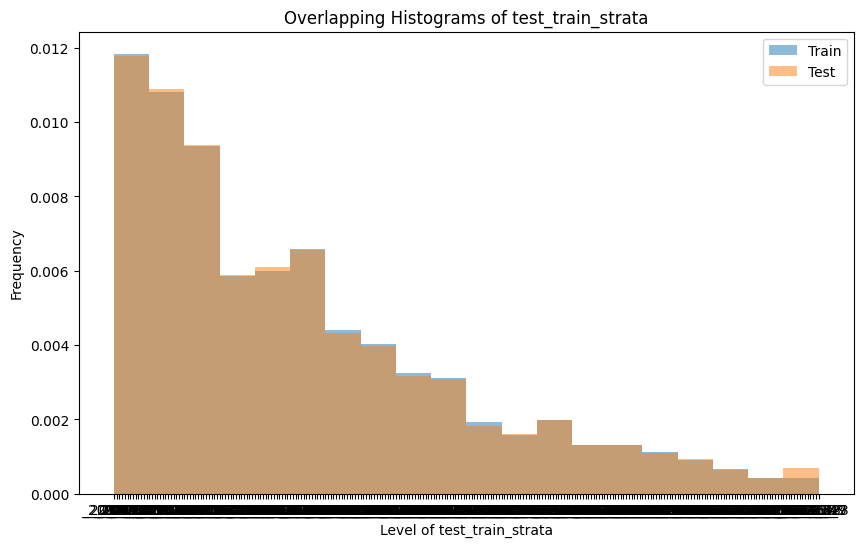

In [172]:
# Define min number of observations per strata
strat_cutoff = 2

# Define number of cv folds
cv_folds = user_input["cv_folds"]

# Get temporary df
df_all_strata = df_dropped_rows_with_nas.copy()

# Attach test_train_strata dummy
df_all_strata["test_train_strata"] = ""

# Attach test_train_strata variables
for var in test_train_strata:
    df_all_strata["test_train_strata"] = df_all_strata["test_train_strata"] + (
        "_" + df_all_strata[var].astype(str)
    )

# Check how many stratification lvls there are
stratification_lvls = df_all_strata["test_train_strata"].nunique()
print(
    f"Stratification levels: {stratification_lvls}, based on variables: {test_train_strata}.\n"
)

# ------------------------------------------------------------------------------------------
df_tmp = df_all_strata.copy()

# Remove rows where stratification level belongs to a group that has less than x observations
stratification_counts = df_all_strata["test_train_strata"].value_counts()
stratification_counts = stratification_counts[stratification_counts < strat_cutoff]
stratification_counts = stratification_counts.index.to_list()

# Define final dataframe
df_tmp = df_tmp.query("test_train_strata not in @stratification_counts")
df_dropped_stratif = df_tmp.copy()

# ------------------------------------------------------------------------------------------
# Test splitting
# Get temporary df
df_tmp = df_dropped_stratif.copy()

# TEST/TRAIN: Test splitting the data into train and test sets
x1, x2, y1, y2 = train_test_split(
    df_tmp.drop(target, axis=1),
    df_tmp[target],
    test_size=test_split,
    random_state=seed_nr,
    stratify=df_tmp["test_train_strata"],
)

print(
    f"Test/Train Split using {int(test_split*100)}% for test set:",
    f"\n - Shape of original dataframe: {df_all_strata.shape} with {df_all_strata['test_train_strata'].nunique()} stratas"
    f"\n - Shape of dataframe with strata removed with less than {strat_cutoff}: {df_dropped_stratif.shape} with {df_dropped_stratif['test_train_strata'].nunique()} stratas"
    f"\n - Unequal distribution in train and test concern {round(100 - df_dropped_stratif.shape[0]/df_all_strata.shape[0] * 100)}% of all observations:",
)

hist_of_variable_in_two_df(x1, "Train", x2, "Test", "test_train_strata")

In [173]:
# VALIDATE/TRAIN: Additionally test if splitting in validation/train works
df_dummy = pd.concat([y1, x1], axis=1)

# Features and target
XXX = df_dummy.drop([target, "test_train_strata"], axis=1)
yyy = df_dummy[target]

# Stratification variable
stratification_var = df_dummy["test_train_strata"]

# Create StratifiedKFold object
skf = StratifiedKFold(n_splits=cv_folds, random_state=seed_nr, shuffle=True)

# Catch warning that is thrown when a strata has less than 1 observations
# warnings.filterwarnings("error", message=".*least populated class in y has only *")

# Split the data using the stratification variable
print(
    f"Expected number: \n\t in train set: {round(len(df_dummy) - len(df_dummy) / cv_folds)}\n\t in validation set: {round(len(df_dummy) / cv_folds)}\n\t in total: {len(df_dummy)}\n"
)


# ------------------------------------------------------------------------------------------
for fold, (train_index, test_index) in enumerate(skf.split(XXX, stratification_var)):
    XXX_train, XXX_test = XXX.iloc[train_index], XXX.iloc[test_index]
    yyy_train, yyy_test = yyy.iloc[train_index], yyy.iloc[test_index]

    # Now, X_train, X_test, y_train, and y_test contain the data for this fold
    # You can proceed with model training and evaluation here
    print(
        f"Fold {fold + 1}: Train set size: {len(XXX_train)}, Validation set size: {len(XXX_test)}"
    )

print("Validate/Train splitting worked ✅")

print(
    f"\nWith a cut_off level of at least {strat_cutoff} observations per strata:"
    f"\nShape before removing strata with less than {strat_cutoff} observations: {df_all_strata.shape}"
    f"\nShape after removing strata with less than {strat_cutoff} observations: {df_tmp.shape}"
    f"\nNumber of removed sites: {df_all_strata.shape[0] - df_tmp.shape[0]} = {round((1 - df_tmp.shape[0] / df_all_strata.shape[0]) * 100, 2)}%"
    f"\nRemaining stratification levels: {df_tmp['test_train_strata'].nunique()}"
)

# Create plots
fig, axs = plt.subplots(1, 2, figsize=(15, 8))

# Plot distribution of stratification levels
df_all_strata["test_train_strata"].value_counts().plot(kind="barh", ax=axs[0])
df_tmp["test_train_strata"].value_counts().plot(kind="barh", ax=axs[1])

# Set titles for subplots
axs[0].set_title("All stratification levels")
axs[1].set_title("Filtered stratification levels")

# Display the plots
plt.show()

Expected number: 
	 in train set: 4722
	 in validation set: 1180
	 in total: 5902



UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.

### Filter Columns

- Filter columns only now that we have removed certain strata. This affects the removal based on %-count!
- Note that apriori filter based on google sheet is done above when encoding NFI variables

#### based on %NAs

In [ ]:
# DROP COLUMNS WITH TOO MANY NA VALUES

# Get temporary df for cell
df_tmp = df_dropped_stratif.copy()

# Unify encoding of missing data (NA into NaN)
df_tmp = df_tmp.fillna(value=pd.NA)

# Get number of rows of dataframe to calculate percentages
n_rows = df_tmp.shape[0]

print("Variables that were dropped because they have too many NAs:")
for my_col in sorted(df_tmp.columns):
    n_na = df_tmp[my_col].isna().sum()
    na_perc = n_na / n_rows

    if na_perc > na_drop_threshold:
        df_tmp = df_tmp.drop(my_col, axis=1)
        print(f" - {my_col:<20} with {n_na:<5} NAs ({round(na_perc*100)}%).")

df_dropped_na_cols = df_tmp.copy()

print("")
print(
    f"👉 df shape changed from: {df_dropped_stratif.shape} to {df_dropped_na_cols.shape}",
    end="",
)
print(
    f" = {df_dropped_stratif.shape[1] - df_dropped_na_cols.shape[1]} variables were dropped."
)

Variables that were dropped because they have too many NAs:
 - acces                with 7391  NAs (100%).
 - autut_1              with 6276  NAs (85%).
 - autut_2              with 1206  NAs (16%).
 - bois_1               with 5229  NAs (71%).
 - bois_2               with 1201  NAs (16%).
 - cam                  with 7378  NAs (100%).
 - cslisi               with 5488  NAs (74%).
 - dcespar1             with 7362  NAs (100%).
 - dcespar2             with 7380  NAs (100%).
 - def5                 with 2349  NAs (32%).
 - dpyr                 with 7391  NAs (100%).
 - elag                 with 6941  NAs (94%).
 - elisi                with 6286  NAs (85%).
 - entp                 with 7238  NAs (98%).
 - hw_day_sum           with 7067  NAs (96%).
 - hw_days_between      with 7380  NAs (100%).
 - hw_dur_max           with 7067  NAs (96%).
 - hw_dur_mean          with 7067  NAs (96%).
 - hw_max_temp          with 7067  NAs (96%).
 - hw_mean_temp         with 7067  NAs (96%).
 - incid_1    

In [ ]:
# Get remaining columns with NA values for imputation later
vars_with_na = df_dropped_na_cols.columns[df_dropped_na_cols.isna().any()].tolist()
vars_with_na = vars_with_na
print("Variables still containing NAs:")
for var in vars_with_na:
    print(f" - {var}")

Variables still containing NAs:
 - instp5
 - asperite
 - dist
 - gest
 - pentexp
 - plisi
 - portance
 - land_use
 - top1_species_age13_mean
 - top1_species_ba_1_sd
 - top1_species_htot_mean
 - top1_species_htot_sd
 - top1_species_ir5_mean
 - top1_species_v_sd
 - max_gdd_before_spring_frost
 - min_doy_of_fall_frost
 - hw_counts
 - mean_of_minimum_2m_air_temperature_in_winter
 - mean_of_minimum_2m_air_temperature_in_spring
 - mean_of_minimum_2m_air_temperature_in_summer
 - mean_of_minimum_2m_air_temperature_in_fall
 - mean_of_total_precipitation_in_winter
 - mean_of_total_precipitation_in_spring
 - mean_of_total_precipitation_in_summer
 - mean_of_total_precipitation_in_fall
 - mean_of_v_component_of_wind_10m_in_winter
 - mean_of_v_component_of_wind_10m_in_spring
 - mean_of_v_component_of_wind_10m_in_summer
 - mean_of_v_component_of_wind_10m_in_fall
 - mean_of_surface_pressure_in_winter
 - mean_of_surface_pressure_in_spring
 - mean_of_surface_pressure_in_summer
 - mean_of_surface_pressur

#### based on user input

In [ ]:
# TODO: Remove variables that have mostly the same values

In [ ]:
# Get temporary df
df_tmp = df_dropped_na_cols.copy()

# Fix user removal input
# If target in variables to remove, remove it
if target in user_input_variable_removal:
    user_input_variable_removal.remove(target)

# If stratification variables in variables to remove, remove them.
# They will be removed later.
for var in test_train_strata:
    if var in user_input_variable_removal:
        user_input_variable_removal.remove(var)

# Remove variables: Setting errors to ignore because some vars may have already been dropped:
print(
    "Variables that have been selected to drop but have been dropped by the routine already: "
)
for var in user_input_variable_removal:
    if var not in df_tmp.columns:
        print(var, end=", ")

df_tmp = df_tmp.drop(columns=user_input_variable_removal, errors="ignore")

# If idp is still in dataframe, remove now explicitly
if "idp" in df_tmp.columns:
    print("Removing idp from dataframe.")
    df_tmp = df_tmp.drop(columns="idp")


df_dropped_user_cols = df_tmp.copy()

print("\n")
print(f"Shape before dropping user selected vars: {df_dropped_na_cols.shape}")
print(f"Shape after dropping user selected vars: {df_dropped_user_cols.shape}")
# print(f"Length of user selected vars to drop: {len(user_input_variable_removal)}") # Does not need to match, so removing

Variables that have been selected to drop but have been dropped by the routine already: 
visite_1, visite_2, census_interval, 

Shape before dropping user selected vars: (7391, 210)
Shape after dropping user selected vars: (7391, 173)


## Get variables to impute

### Encode categorical variables

In [ ]:
# ! Output of this cell should be empty because categorical variables with NA values should not be in the data.

# GET CATEGORICAL VARIABLES WITH NA VALUES
# Get all categorical variables that have NAs in them
# cats_with_na = vars_with_na[vars_with_na.isin(vars_to_ohe)].tolist()
cats_with_na = [var for var in vars_with_na if var in vars_to_ohe]

print("Categorical Variables that still have NA (NA will be turned into 'missing'):")
for var in cats_with_na:
    print(" ", var, end=", ")
print("\n")

# Replace NA values with "missing"
for var in cats_with_na:
    df_dropped_user_cols[var] = df_dropped_user_cols[var].fillna("missing")

print("Variables encoded to be categorical:")
for var in vars_to_ohe:
    if var in df_dropped_user_cols.columns:
        df_dropped_user_cols[var] = df_dropped_user_cols[var].astype(str)
        print(f" - {var}", end="\n")

# Make sure idp is kept as int to merge with gee data later
# df_dropped_user_cols["idp"] = df_dropped_user_cols["idp"].astype(int)

Categorical Variables that still have NA (NA will be turned into 'missing'):
  instp5,   land_use, 

Variables encoded to be categorical:
 - andain
 - bord
 - instp5
 - integr
 - iti
 - tplant
 - csa_1
 - csa_2
 - nincid_2
 - cover_change
 - gre
 - human_activity_var
 - land_use
 - dom_nr1_tree_class_fct
 - dom_nr2_tree_class_fct
 - dom_nr3_tree_class_fct
 - dom_rest_tree_class_fct
 - top1_species_nfi
 - top2_species_nfi
 - top3_species_nfi


In [ ]:
# GET NUMERICAL VARIABLES WITH NA VALUES
numerics_with_na = [
    var
    for var in df_dropped_user_cols.columns
    if df_dropped_user_cols[var].dtype != "O"
]  # No categorical variables
numerics_with_na = [
    var for var in numerics_with_na if var not in date_cols
]  # No date time variables
numerics_with_na = [
    var for var in numerics_with_na if var in vars_with_na
]  # Reduce to variables that hold NA values
numerics_with_na = [
    var for var in numerics_with_na if var != target
]  # Make sure target is not in the list

print("Numerical variables with NA values to be imputed:")
counter = 0
for var in numerics_with_na:
    print(f" {counter}. {var}")
    counter = counter + 1

Numerical variables with NA values to be imputed:
 0. asperite
 1. dist
 2. gest
 3. pentexp
 4. plisi
 5. portance
 6. top1_species_age13_mean
 7. top1_species_ba_1_sd
 8. top1_species_htot_mean
 9. top1_species_htot_sd
 10. top1_species_ir5_mean
 11. top1_species_v_sd
 12. max_gdd_before_spring_frost
 13. min_doy_of_fall_frost
 14. hw_counts
 15. mean_of_minimum_2m_air_temperature_in_winter
 16. mean_of_minimum_2m_air_temperature_in_spring
 17. mean_of_minimum_2m_air_temperature_in_summer
 18. mean_of_minimum_2m_air_temperature_in_fall
 19. mean_of_total_precipitation_in_winter
 20. mean_of_total_precipitation_in_spring
 21. mean_of_total_precipitation_in_summer
 22. mean_of_total_precipitation_in_fall
 23. mean_of_v_component_of_wind_10m_in_winter
 24. mean_of_v_component_of_wind_10m_in_spring
 25. mean_of_v_component_of_wind_10m_in_summer
 26. mean_of_v_component_of_wind_10m_in_fall
 27. mean_of_surface_pressure_in_winter
 28. mean_of_surface_pressure_in_spring
 29. mean_of_surface

## ✂️ Split Data

Depending on the variables selected for stratification, the data will be reduced to a subset that holds enough entries for an equal split. Since we are going to perform a RFE with CV, we must ensure that for the train set, there are enough observation per stratification level, so that equally distributed folds can be created.

❌ TODO:
- [ ] Add check for stratification variables. Per hand, find how many observation must be in the data at least to allow for a 5-fold CV.

### Do Split

In [37]:
# Get temporary df
df_tmp = df_dropped_user_cols.copy()

# Get all variables names before one-hot encoding
all_var_names_before_ohe = sorted(df_tmp.columns.to_list())

# Set variables to not ohe:
my_vars_not_to_ohe = ["test_train_strata"]

# Do the OHE
df_tmp = do_ohe(df_tmp, my_vars_not_to_ohe, verbose=True)

# Get all variables names after one-hot encoding
all_var_names_after_ohe = sorted(df_tmp.columns.to_list())

# Get variable dictionary
var_ohe_dict = {}
for var in all_var_names_before_ohe:
    sub_vars = []

    if var in all_var_names_after_ohe:
        # If the variable was not ohe, it stays the same
        var_ohe_dict[var] = [var]
        continue
    else:
        # If the variable was ohe, search for pattern and add it
        pattern = r"^" + var + r"_.*"
        for sub_var in all_var_names_after_ohe:
            # print(pattern, sub_var, re.match(pattern, sub_var))
            if re.match(pattern, sub_var):
                sub_vars.append(sub_var)
    var_ohe_dict[var] = sub_vars

do_ohe(): 
 - Shape before OHE:		 (7391, 173) 
 - Shape after OHE:		 (7391, 395) 
 - Change in Nr. of columns:	 222 (dropped: 20, added: 242) 
 - Variables that were ohe:	 andain | bord | cover_change | csa_1 | csa_2 | dom_nr1_tree_class_fct | dom_nr2_tree_class_fct | dom_nr3_tree_class_fct | dom_rest_tree_class_fct | gre | human_activity_var | instp5 | integr | iti | land_use | nincid_2 | top1_species_nfi | top2_species_nfi | top3_species_nfi | tplant 
 - New variables:		 andain_0 | andain_1 | bord_0 | bord_1 | cover_change_Clearcut | cover_change_Decreased Tree Cover | cover_change_Increased Tree Cover | cover_change_No Change | csa_1_1 | csa_1_2 | csa_1_3 | csa_1_5 | csa_2_1 | csa_2_2 | csa_2_3 | csa_2_5 | csa_2_7 | dom_nr1_tree_class_fct_broadleaf | dom_nr1_tree_class_fct_pinus | dom_nr2_tree_class_fct_broadleaf | dom_nr2_tree_class_fct_none | dom_nr2_tree_class_fct_pinus | dom_nr3_tree_class_fct_none | dom_rest_tree_class_fct_none | gre_A | gre_B | gre_C | gre_D | gre_E | gre_F | 

In [38]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df_tmp.drop(target, axis=1),
    df_tmp[target],
    test_size=test_split,
    random_state=seed_nr,
    stratify=df_tmp["test_train_strata"],
)

# Merge dataframes back for easier handling
Xy_train_raw = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
Xy_test_raw = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

print(
    f"Shape of Xy_train_raw: {Xy_train_raw.shape}",
    f"\nShape of Xy_test_raw: {Xy_test_raw.shape}",
)

Shape of Xy_train_raw: (5912, 395) 
Shape of Xy_test_raw: (1479, 395)


In [39]:
# # Save stratification labels for REFCV below
# X_train_strata = X_train["test_train_strata"]

# # Remove stratification column from test and train dataset
# remove_these = [
#     "test_train_strata"
# ]  # + test_train_strata # TODO Should the stratification variables be removed?
# X_train = X_train.drop(remove_these, axis=1)
# X_test = X_test.drop(remove_these, axis=1)

# print(f"Shape of X_train: {X_train.shape}")
# print(f"Shape of X_test: {X_test.shape}")
# print(f"Shape of y_train: {y_train.shape}")
# print(f"Shape of y_test: {y_test.shape}")
# print(f"Shape of Xy_for_refcv: {Xy_for_refcv.shape}")
# print(
#     f"Percentual contribution of X_test to total data (should be {test_split*100}): {round(len(X_test) / (len(X_train) + len(X_test))*100, 2)}"
# )

## Preprocessing

In [40]:
Xy_train_imputed, Xy_test_imputed = impute_numerical_na(
    Xy_train_raw,
    Xy_test_raw,
    target,
    n_neighbours=10,
    vars_not_to_impute=test_train_strata,
)

impute_numerical_na(): 
 - Shape of Xy_train before imputation: (5912, 395) 
 - Shape of Xy_train before imputation: (5912, 395) 
 
 - Shape of Xy_test before imputation: (1479, 395) 
 - Shape of Xy_test before imputation: (1479, 395) 
 
 - Out of 394, 123 had NA values and were imputed using KNN with 10 neighbours. 
 - Imputed variables: asperite | dist | gest | hw_counts | max_gdd_before_spring_frost | mean_of_dewpoint_2m_temperature_in_fall | mean_of_dewpoint_2m_temperature_in_spring | mean_of_dewpoint_2m_temperature_in_summer | mean_of_dewpoint_2m_temperature_in_winter | mean_of_landsat_EVI_in_fall | mean_of_landsat_EVI_in_spring | mean_of_landsat_EVI_in_summer | mean_of_landsat_EVI_in_winter | mean_of_landsat_NDVI_in_fall | mean_of_landsat_NDVI_in_spring | mean_of_landsat_NDVI_in_summer | mean_of_landsat_NDVI_in_winter | mean_of_maximum_2m_air_temperature_in_fall | mean_of_maximum_2m_air_temperature_in_spring | mean_of_maximum_2m_air_temperature_in_summer | mean_of_maximum_2m_air_

## Fit Model

### Random Grid Search

ATTENTION! GRID SEARCHES NEED TO BE UPDAATED

In [41]:
if user_input["do_random_search"]:
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.model_selection import RandomizedSearchCV

    # Number of trees in random forest
    # n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
    n_estimators = [int(x) for x in np.linspace(start=10, stop=2500, num=5)]

    # Number of features to consider at every split
    max_features = ["auto", "sqrt"]

    # Maximum number of levels in tree
    # max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
    max_depth = [int(x) for x in np.linspace(1, 25, num=5)]
    max_depth.append(None)

    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]

    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]

    # Method of selecting samples for training each tree
    bootstrap = [True, False]

    # Create the random grid
    random_grid = {
        "n_estimators": n_estimators,
        "max_features": max_features,
        "max_depth": max_depth,
        "min_samples_split": min_samples_split,
        "min_samples_leaf": min_samples_leaf,
        # "bootstrap": bootstrap,
    }

    for key, value in random_grid.items():
        print(f"{key}: {value}")

    # Use the random grid to search for best hyperparameters
    # First create the base model to tune
    rf = RandomForestRegressor()

    # Random search of parameters, using 3 fold cross validation,
    # search across 100 different combinations, and use all available cores
    rf_random = RandomizedSearchCV(
        estimator=rf,
        param_distributions=random_grid,
        n_iter=100,
        cv=5,
        verbose=1,
        random_state=seed_nr,
        n_jobs=-1,
        return_train_score=True,
    )

    # Fit the random search model
    rf_random.fit(X_train, y_train)

    # Print results
    print(
        rf_random.best_estimator_
    )  # Output: RandomForestRegressor(max_features='sqrt', n_estimators=1255)
    print(rf_random.best_score_)  # Output: 0.18764794450728156
    print(rf_random.best_params_)
else:
    # Return best variables from previous search
    best_params = {
        "n_estimators": 1255,
        "min_samples_split": 2,
        "min_samples_leaf": 1,
        "max_features": "sqrt",
        "max_depth": None,
        "bootstrap": True,
    }

### Prescribed Grid Search

In [42]:
if user_input["do_prescribed_search"]:
    # Define the parameter grid
    param_grid = {
        "n_estimators": [
            10,
            50,
            100,
            500,
            1000,
            2500,
        ],  # , 1000, 2000, 5000],  # 500, 1000, 2500],
        "max_features": ["sqrt", "log2"],  # ["auto", "sqrt", "log2"],
        "max_depth": [5, 6, 8, 15, 30],  # 10],  # , 50, 100],
        # 'criterion' :['gini', 'entropy']
    }

    # Create a base model
    rf = RandomForestRegressor()

    # Instantiate the grid search model
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=5,
        n_jobs=-1,
        verbose=1,
        return_train_score=True,
    )

    # Fit the grid search to the data
    grid_search.fit(X_train, y_train)

    plot_grid_search_results(grid_search)
else:
    # Return best variables from previous search
    best_params = {
        "n_estimators": 1255,
        "min_samples_split": 2,
        "min_samples_leaf": 1,
        "max_features": "sqrt",
        "max_depth": None,
        "bootstrap": True,
    }

### 🔄 REFCV

In [212]:
# Set parameters
debug_stop = True
debug_stop_after_n_iterations = 10

vars_to_remove = []
cv_folds = user_input["cv_folds"]
features_to_remove_above100 = 100
features_to_remove_above50 = 10
features_to_remove_above30 = 3
features_to_remove_below30 = 1

# --------------------------------------------------------
# Prepare final dataframe:
df_cvmetrics_per_nfeatures = pd.DataFrame(
    {
        "n_features": [],
        "r2": [],
        "r2_sd": [],
        "rmse": [],
        "rmse_sd": [],
        "mae": [],
        "mae_sd": [],
        "vars_to_remove": [],
    },
)

# Define model to fit
rf_rfe = RandomForestRegressor(**best_params, random_state=seed_nr, n_jobs=-1)

# Set iteration counter
iteration_count = 0

# --------------------------------------------------------
# START REF-CV
# --------------------------------------------------------
while True:
    # Set vectors to track metrics
    v_r2 = []
    v_rmse = []
    v_mae = []

    # --------------------------------------------------------
    # CROSS-VALIDATION
    # --------------------------------------------------------

    # Remove variables of previous iteration
    Xy_refcv = Xy_train_raw.copy().drop(columns=vars_to_remove).reset_index(drop=True)

    # Get current number of features, accounting for target and strata
    remaining_features = Xy_refcv.drop(columns=[target, "test_train_strata"]).columns
    remaining_features_numbers = Xy_refcv.shape[1] - 2 # Adding -2 for target and strata
    print(
        f"\nIteration {iteration_count}\tCurrent Number of features: {remaining_features_numbers}"
    )  

    # If no more features to remove, break loop
    if (remaining_features_numbers) == 0:
        break

    # Create folds
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True) # TODO: Check if seed should be fixed or not. Currently creates the same splits every time.
    
    # Create stratified folds
    for fold, (train_index, test_index) in enumerate(
        skf.split(Xy_refcv, Xy_refcv["test_train_strata"])
    ):
        # Get current fold
        Xy_refcv_train, Xy_refcv_val = (
            Xy_refcv.iloc[train_index],
            Xy_refcv.iloc[test_index],
        )

        X_train_if = Xy_refcv_train.drop(
            columns=vars_to_remove + [target, "test_train_strata"],
            errors="ignore",
        )
        y_train_if = Xy_refcv_train[target]

        X_val_if = Xy_refcv_val.drop(
            columns=vars_to_remove + [target, "test_train_strata"],
            errors="ignore",
        )
        y_val_if = Xy_refcv_val[target]

        # Print information
        print(
            f" - Fold {fold + 1} | {cv_folds}:",
            f"\t | Validation/Test = {round(len(Xy_refcv_val) / (len(Xy_refcv_val) + len(Xy_refcv_train)) * 100)}/{round(len(Xy_refcv_train) / (len(Xy_refcv_val) + len(Xy_refcv_train)) * 100)}",
            f"\t | Shape of X_train_if: {X_train_if.shape} and y_train_if: {y_train_if.shape}",
            f"\t | Shape of X_val_if: {X_val_if.shape} and y_val_if: {y_val_if.shape}",
            end=" | ",
        )

        # Preprocess data
        numerics_with_na_red = [
            var for var in numerics_with_na if var in Xy_refcv.columns
        ]

        print("Preprocessing data...", end=" ")

        X_train_if, X_val_if = pp_this(
            vars_to_ohe,
            numerics_with_na_red,
            X_train_if,
            X_val_if,
            current_dir,
            verbose=False,
        )

        print("Fit model...", end=" ")

        # Fit model
        rf_rfe.fit(X_train_if, y_train_if)

        # Get metrics on validation set
        y_pred_val = rf_rfe.predict(X_val_if)
        v_r2 = v_r2 + [r2_score(y_val_if, y_pred_val)]
        v_rmse = v_rmse + [np.sqrt(mean_squared_error(y_val_if, y_pred_val))]
        v_mae = v_mae + [mean_absolute_error(y_val_if, y_pred_val)]

        # --------------------------------------------------------
        # End of fold
        # --------------------------------------------------------

    # --------------------------------------------------------
    # FEATURE IMPORTANCE
    # --------------------------------------------------------
    # Calculate feature importance
    print("Calculate feature importance...")

    vars_to_ohe_red = [var for var in vars_to_ohe if var in Xy_refcv.columns]

    agg_vip, agg_dict = show_top_predictors(
        X_train_if,
        vars_to_ohe_red,
        rf_rfe,
        with_aggregation=True,
        verbose=False,
    )

    # Set number of variables to remove
    n_to_remove = features_to_remove_below30

    if remaining_features_numbers > 30:
        n_to_remove = features_to_remove_above30

    if remaining_features_numbers > 50:
        n_to_remove = features_to_remove_above50

    if remaining_features_numbers > 100:
        n_to_remove = features_to_remove_above100

    # Get names of variables to remove
    new_to_remove = agg_vip.tail(n_to_remove)["Feature"].to_list()
    vars_to_remove = vars_to_remove + new_to_remove

    # print(f"\t - New variables to remove, {len(new_to_remove)}: {new_to_remove}")
    # print(f"\t - All variables to remove, {len(vars_to_remove)}: {vars_to_remove}")

    # --------------------------------------------------------
    # Save to output
    # --------------------------------------------------------
    # Save rf metrics for current number of features

    df_new_row = pd.DataFrame(
        {
            "n_features": [remaining_features_numbers],
            "r2": np.mean(v_r2),
            "r2_sd": np.std(v_r2),
            "rmse": np.mean(v_rmse),
            "rmse_sd": np.std(v_rmse),
            "mae": np.mean(v_mae),
            "mae_sd": np.std(v_mae),
            "n_vars_to_remove": [len(vars_to_remove)],
            "vars_to_remove": [", ".join(vars_to_remove)],
            "remaining_vars": [", ".join(remaining_features.to_list())],
            # "n_remaining_vars": [len(remaining_features.to_list())],
        }
    )

    df_cvmetrics_per_nfeatures = pd.concat(
        [df_cvmetrics_per_nfeatures, df_new_row], axis=0
    )

    iteration_count = iteration_count + 1

    if debug_stop and iteration_count == debug_stop_after_n_iterations:
        break


Iteration 0	Current Number of features: 171
 - Fold 1 | 5: 	 | Validation/Test = 20/80 	 | Shape of X_train_if: (4729, 171) and y_train_if: (4729,) 	 | Shape of X_val_if: (1183, 171) and y_val_if: (1183,) | Preprocessing data... Fit model...
 - Fold 2 | 5: 	 | Validation/Test = 20/80 	 | Shape of X_train_if: (4729, 171) and y_train_if: (4729,) 	 | Shape of X_val_if: (1183, 171) and y_val_if: (1183,) | Preprocessing data... Fit model...
 - Fold 3 | 5: 	 | Validation/Test = 20/80 	 | Shape of X_train_if: (4730, 171) and y_train_if: (4730,) 	 | Shape of X_val_if: (1182, 171) and y_val_if: (1182,) | Preprocessing data... Fit model...
 - Fold 4 | 5: 	 | Validation/Test = 20/80 	 | Shape of X_train_if: (4730, 171) and y_train_if: (4730,) 	 | Shape of X_val_if: (1182, 171) and y_val_if: (1182,) | Preprocessing data... Fit model...
 - Fold 5 | 5: 	 | Validation/Test = 20/80 	 | Shape of X_train_if: (4730, 171) and y_train_if: (4730,) 	 | Shape of X_val_if: (1182, 171) and y_val_if: (1182,) | 

In [213]:
df_cvmetrics_per_nfeatures.sort_values("rmse", ascending=True).head(5)

,n_features,r2,r2_sd,rmse,rmse_sd,mae,mae_sd,vars_to_remove,n_vars_to_remove,remaining_vars
0,161.0,0.492207,0.027620,1.890804,0.133928,1.151212,0.042216,"perc_trees_mistletoe_v2, nlisi5, perc_trees_fi...",20.0,"andain, bord, integr, iti, tplant, asperite, d..."
0,171.0,0.486425,0.028341,1.901783,0.138523,1.158824,0.043685,"perc_trees_mistletoe_v2, nlisi5, perc_trees_fi...",10.0,"andain, bord, instp5, integr, iti, tplant, asp..."


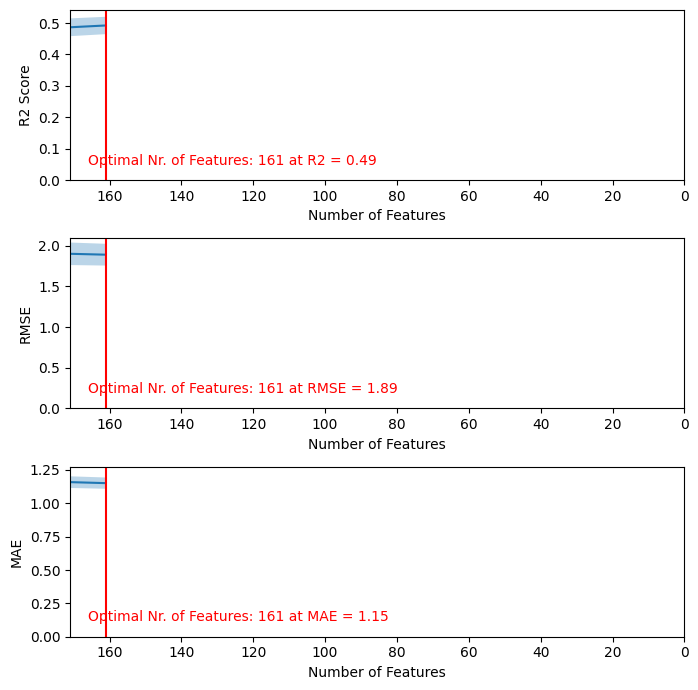

In [214]:
# Get max number of features
x_max = df_cvmetrics_per_nfeatures["n_features"].max()

# Start plotting
fig, axs = plt.subplots(3, 1, figsize=(7, 7))

# PLOT: R2 ----------------------------------------------
# Get max R2
max_r2 = df_cvmetrics_per_nfeatures.sort_values(by="r2", ascending=False).iloc[0, 1]
# Get n_features at max R2
max_r2_features = df_cvmetrics_per_nfeatures.sort_values(by="r2", ascending=False).iloc[
    0, 0
]
axs[0].plot(df_cvmetrics_per_nfeatures["n_features"], df_cvmetrics_per_nfeatures["r2"])
axs[0].fill_between(
    df_cvmetrics_per_nfeatures["n_features"],
    df_cvmetrics_per_nfeatures["r2"] - df_cvmetrics_per_nfeatures["r2_sd"],
    df_cvmetrics_per_nfeatures["r2"] + df_cvmetrics_per_nfeatures["r2_sd"],
    alpha=0.3,
)
axs[0].set_xlabel("Number of Features")
axs[0].set_ylabel("R2 Score")
axs[0].set_xlim(x_max, 0)
axs[0].set_ylim(0, (max_r2 + max_r2 * 0.1))

# Add red vertical line for highest R2 score
axs[0].axvline(x=max_r2_features, color="red")

# Add text of max_r2_features to axs[0] in red
axs[0].text(
    x_max - 5,
    max_r2 * 0.1,
    f"Optimal Nr. of Features: {int(max_r2_features)} at R2 = {round(max_r2,2)}",
    color="red",
)

# PLOT: RMSE ----------------------------------------------
# Get min rmse
min_rmse = df_cvmetrics_per_nfeatures.sort_values(by="rmse", ascending=True).iloc[0, 3]
max_rmse = df_cvmetrics_per_nfeatures.sort_values(by="rmse", ascending=False).iloc[0, 3]

# Get n_features at min rmse
min_rmse_features = df_cvmetrics_per_nfeatures.sort_values(
    by="rmse", ascending=True
).iloc[0, 0]

axs[1].plot(
    df_cvmetrics_per_nfeatures["n_features"], df_cvmetrics_per_nfeatures["rmse"]
)
axs[1].fill_between(
    df_cvmetrics_per_nfeatures["n_features"],
    df_cvmetrics_per_nfeatures["rmse"] - df_cvmetrics_per_nfeatures["rmse_sd"],
    df_cvmetrics_per_nfeatures["rmse"] + df_cvmetrics_per_nfeatures["rmse_sd"],
    alpha=0.3,
)
axs[1].set_xlabel("Number of Features")
axs[1].set_ylabel("RMSE")
axs[1].set_xlim(x_max, 0)
axs[1].set_ylim(0, (max_rmse + max_rmse * 0.1))

# Add red vertical line for lowest RMSE score
axs[1].axvline(x=min_rmse_features, color="red")

# Add text
axs[1].text(
    x_max - 5,
    min_rmse * 0.1,
    f"Optimal Nr. of Features: {int(min_rmse_features)} at RMSE = {round(min_rmse,2)}",
    color="red",
)

# PLOT: MAE ----------------------------------------------
min_mae = df_cvmetrics_per_nfeatures.sort_values(by="mae", ascending=True).iloc[0, 5]
max_mae = df_cvmetrics_per_nfeatures.sort_values(by="mae", ascending=False).iloc[0, 5]
min_mae_features = df_cvmetrics_per_nfeatures.sort_values(
    by="mae", ascending=True
).iloc[0, 0]

axs[2].plot(df_cvmetrics_per_nfeatures["n_features"], df_cvmetrics_per_nfeatures["mae"])
axs[2].fill_between(
    df_cvmetrics_per_nfeatures["n_features"],
    df_cvmetrics_per_nfeatures["mae"] - df_cvmetrics_per_nfeatures["mae_sd"],
    df_cvmetrics_per_nfeatures["mae"] + df_cvmetrics_per_nfeatures["mae_sd"],
    alpha=0.3,
)
axs[2].set_xlabel("Number of Features")
axs[2].set_ylabel("MAE")
axs[2].set_xlim(x_max, 0)
axs[2].set_ylim(0, (max_mae + max_mae * 0.1))

# Add red vertical line for lowest RMSE score
axs[2].axvline(x=min_mae_features, color="red")

# Add text
axs[2].text(
    x_max - 5,
    min_mae * 0.1,
    f"Optimal Nr. of Features: {int(min_mae_features)} at MAE = {round(min_mae,2)}",
    color="red",
)


# LAYOUT
plt.tight_layout()
plt.show()

In [219]:
X_train

,asperite,dist,gest,nlisi5,pentexp,plisi,portance,campagne_1,site_ba_prc_cut_at_v2,site_ba_prc_dead_at_v1,...,top3_species_nfi_67,top3_species_nfi_69,top3_species_nfi_7,top3_species_nfi_71,top3_species_nfi_72,top3_species_nfi_73,top3_species_nfi_74,top3_species_nfi_8,top3_species_nfi_9,top3_species_nfi_none
0,0.0,2.0,2.0,0,0.0,0.2,1.0,2016,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,2.0,0.0,0,0.0,1.0,1.0,2012,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,2.0,0.0,0,4.0,0.0,1.8,2011,0.0,0.099149,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,2.0,0,0.0,0.0,1.0,2014,0.0,0.068899,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,2.0,0,0.0,0.0,2.0,2011,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5907,0.0,0.0,2.0,0,0.0,0.0,1.0,2010,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5908,1.0,1.0,0.0,0,1.0,1.0,1.0,2015,0.0,0.291736,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5909,0.0,0.0,2.0,0,0.0,0.0,1.0,2015,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5910,0.0,1.0,2.0,0,2.0,0.0,1.0,2016,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [215]:
best_model_vars = (
    df_cvmetrics_per_nfeatures.sort_values(by="r2", ascending=False)["remaining_vars"]
    .iloc[0]
    .split(", ")
)

X_train[best_model_vars]

KeyError: "['andain', 'bord', 'integr', 'iti', 'tplant', 'csa_1', 'csa_2', 'nincid_2', 'cover_change', 'gre', 'human_activity_var', 'land_use', 'dom_nr1_tree_class_fct', 'dom_nr2_tree_class_fct', 'top1_species_nfi', 'top2_species_nfi', 'top3_species_nfi'] not in index"

In [ ]:
# Get subset of best model variables
best_model_vars = (
    df_cvmetrics_per_nfeatures.sort_values(by="r2", ascending=False)["remaining_vars"]
    .iloc[0]
    .split(", ")
)

# Remove variables from X_train
X_train_fin = X_train.copy()[best_model_vars]
X_test_fin = X_test.copy()[best_model_vars]

# Get subset of all numerical values with at least one NA in X_train_fin or X_test_fin
all_numericals_with_na = (
    X_train_fin.columns[
        (X_train_fin.dtypes != "O") & (X_train_fin.isna().any())
    ].tolist()
    + X_test_fin.columns[
        (X_test_fin.dtypes != "O") & (X_test_fin.isna().any())
    ].tolist()
)

# Remove duplicates from subset
all_numericals_with_na = list(set(all_numericals_with_na))

# Get subset of all categorical values
all_categoricals = X_train_fin.columns[X_train_fin.dtypes == "O"].tolist()

# Get subset of all categorical values with at least one NA in X_train_fin or X_test_fin (SHOULD BE EMPTY!!!)
all_categoricals_with_na = X_train_fin.columns[
    (X_train_fin.dtypes == "O")
    & (X_train_fin.isna().any()) + (X_test_fin.dtypes == "O")
    & (X_test_fin.isna().any())
].tolist()

print(f"all_categoricals_with_na: {all_categoricals_with_na}")

# Pre-process data
X_train_fin, X_test_fin = pp_this(
    all_categoricals,
    all_numericals_with_na,
    X_train_fin,
    X_test_fin,
    current_dir,
)

all_categoricals_with_na: []
Shape of X_train after pre-processing: (3511, 135)
Shape of X_test after pre-processing: (878, 135)

Newly added variables 117: 
nincid_2_0 | nincid_2_1 | nincid_2_2 | nincid_2_3 | nincid_2_4 | nincid_2_5 | top1_species_10 | top1_species_11 | top1_species_12 | top1_species_17 | top1_species_19 | top1_species_2 | top1_species_24 | top1_species_3 | top1_species_5 | top1_species_51 | top1_species_52 | top1_species_57 | top1_species_61 | top1_species_62 | top1_species_64 | top1_species_9 | top2_species_10 | top2_species_11 | top2_species_12 | top2_species_13 | top2_species_14 | top2_species_15 | top2_species_17 | top2_species_18 | top2_species_19 | top2_species_2 | top2_species_20 | top2_species_21 | top2_species_22 | top2_species_23 | top2_species_24 | top2_species_25 | top2_species_27 | top2_species_29 | top2_species_3 | top2_species_31 | top2_species_33 | top2_species_34 | top2_species_38 | top2_species_4 | top2_species_40 | top2_species_41 | top2_species_49

### Fit final model

In [137]:
# ADJUST BASED ON WHAT DF I WANT TO USE
Xy_train_final = Xy_train_imputed.copy()
Xy_test_final = Xy_test_imputed.copy()

In [138]:
# Make sure to remove stratification and target from X_train_final and X_test_final
X_train_final = Xy_train_final.drop(columns=[target, "test_train_strata"])
X_test_final = Xy_test_final.drop(columns=[target, "test_train_strata"])

y_train_final = Xy_train_final[target]
y_test_final = Xy_test_final[target]

In [140]:
# Fit the model to the training data
rf_best = RandomForestRegressor(
    **best_params, random_state=seed_nr, n_jobs=-1
)  # Create best model
rf_best.fit(X_train_final, y_train_final)

RandomForestRegressor(max_features='sqrt', n_estimators=1255, n_jobs=-1,
                      random_state=42)

## Evaluate Model

### Variable Importance

In [214]:
rf_in = rf_best
ignore_these = [target, "test_train_strata"]
X_train_in = X_train_final
dict_ohe_in = var_ohe_dict
with_aggregation = True
n_predictors = 20
verbose = True

assessing_top_predictors()... 
 - Number of columns in X_train_in is equal to number of rows in df_featimp_org: True 
 - Number of vars in training set is equal to number of rows in df_featimp_agg: False 
 - Size of original df_featimp_org: (393, 3) 
 - Size of aggregated df_featimp_agg: (0, 3)


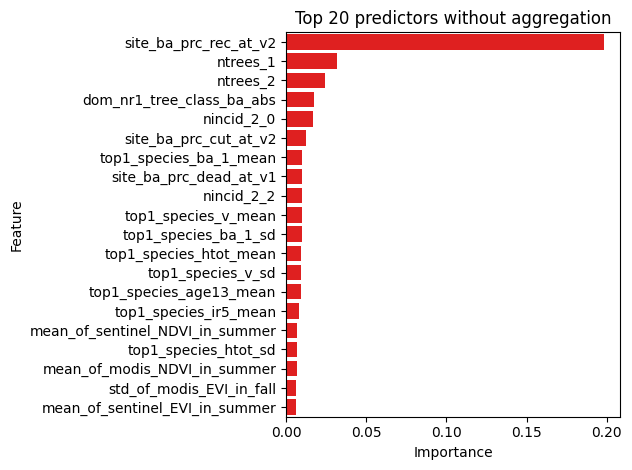

In [241]:
# show_top_predictors(X_train_fin, vars_to_ohe, rf_best, with_aggregation=False)
df_featimp_noagg = assessing_top_predictors(
    rf_in=rf_best,
    ignore_these=[target, "test_train_strata"],
    X_train_in=X_train_final,
    dict_ohe_in=var_ohe_dict,
    with_aggregation=False,
    n_predictors=20,
    verbose=True,
)

assessing_top_predictors()... 
 - Number of columns in X_train_in is equal to number of rows in df_featimp_org: True 
 - Number of vars in training set is equal to number of rows in df_featimp_agg: True 
 - Size of original df_featimp_org: (393, 3) 
 - Size of aggregated df_featimp_agg: (171, 6)


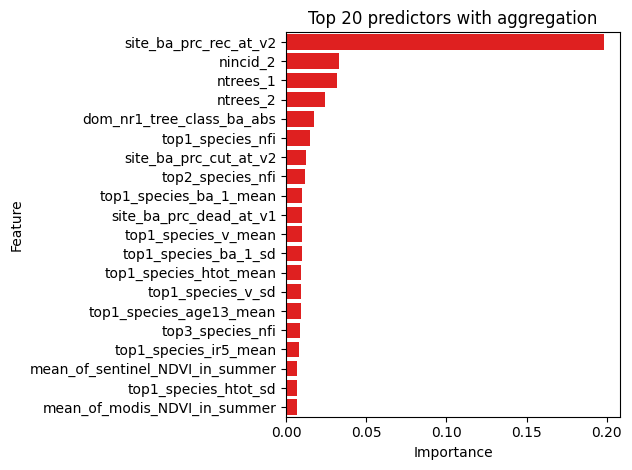

In [237]:
# show_top_predictors(X_train_fin, vars_to_ohe, rf_best, with_aggregation=True)
df_featimp_withagg = assessing_top_predictors(
    rf_in=rf_best,
    ignore_these=[target, "test_train_strata"],
    X_train_in=X_train_final,
    dict_ohe_in=var_ohe_dict,
    with_aggregation=True,
    n_predictors=20,
    verbose=True,
)

### Mod-Obs

R2 score:  0.5229967939253561
RMSE:  1.7889897955818277
MAE:  1.1228736606147145


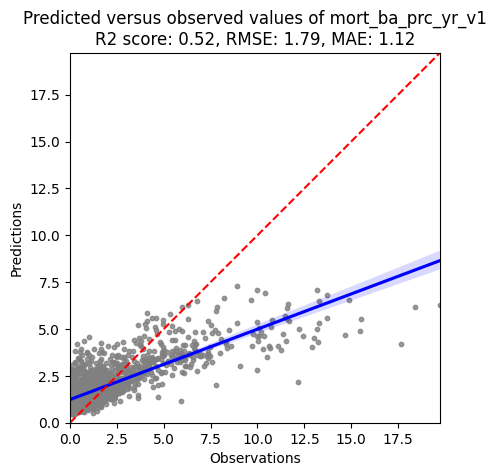

In [242]:
model_evaluation(rf_best, X_test_final, y_test_final)

## Save Model

In [ ]:
import pickle

# Pickle model
with open(f"{current_dir}/final_model.pkl", "wb") as f:
    pickle.dump(rf_best, f)

# Pickle test data
with open(f"{current_dir}/X_test.pkl", "wb") as f:
    pickle.dump(X_test, f)

with open(f"{current_dir}/y_test.pkl", "wb") as f:
    pickle.dump(y_test, f)

---

In [ ]:
# from sklearn.feature_selection import RFECV
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.datasets import make_regression

# # Example dataset
# X, y = make_regression(
#     n_samples=100, n_features=10, n_informative=2, random_state=0, shuffle=False
# )

# # Split data
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# # RandomForestRegressor model
# regr = RandomForestRegressor(n_estimators=100, random_state=0)

# # RFECV with neg_mean_squared_error scorer
# rfecv = RFECV(estimator=regr, step=1, cv=5, scoring="neg_mean_absolute_error")
# rfecv = rfecv.fit(X_train, y_train)

# print("Optimal number of features : %d" % rfecv.n_features_)

# n_scores = len(rfecv.cv_results_["mean_test_score"])
# plt.figure()
# plt.xlabel("Number of features selected")
# plt.ylabel("Mean test accuracy")
# plt.errorbar(
#     range(min_features_to_select, n_scores + min_features_to_select),
#     rfecv.cv_results_["mean_test_score"],
#     yerr=rfecv.cv_results_["std_test_score"],
# )
# plt.title("Recursive Feature Elimination \nwith correlated features")
# plt.show()

In [ ]:
# from sklearn.feature_selection import RFECV
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.datasets import make_regression

# # Example dataset
# X, y = make_regression(
#     n_samples=100, n_features=10, n_informative=2, random_state=0, shuffle=False
# )

# # Split data
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# # RandomForestRegressor model
# regr = RandomForestRegressor(n_estimators=100, random_state=0)

# # RFECV with neg_mean_squared_error scorer
# rfecv = RFECV(estimator=regr, step=1, cv=5, scoring="r2")
# rfecv = rfecv.fit(X_train, y_train)

# print("Optimal number of features : %d" % rfecv.n_features_)

# n_scores = len(rfecv.cv_results_["mean_test_score"])
# plt.figure()
# plt.xlabel("Number of features selected")
# plt.ylabel("Mean test accuracy")
# plt.errorbar(
#     range(min_features_to_select, n_scores + min_features_to_select),
#     rfecv.cv_results_["mean_test_score"],
#     yerr=rfecv.cv_results_["std_test_score"],
# )
# plt.title("Recursive Feature Elimination \nwith correlated features")
# plt.show()

In [ ]:
# for x in tree_vars["var"]:
#     print(x)
# # df_tmp["instp5"].replace("0.0", "0")

# "acci" in tree_vars["var"].to_list()